## Shear bands

This series of notebook explores shear band emergence. The models are based on 


Spiegelman, Marc, Dave A. May, and Cian R. Wilson. "On the solvability of incompressible Stokes with viscoplastic rheologies in geodynamics." Geochemistry, Geophysics, Geosystems (2016).

We first implement the instantaneous model described in that paper, and then look at the at series of extensions

* mohr-coloumb criteria as in kaus 

* transverse isotropic plasticity

* elasticity

* sticky air vs neumann


* time dependence, hardening/softening

questions:

* how do we get the plastic part of the strain
* can we control the solver - i.e do the Picard iterations manually
* how should we do the pressure split for long term models?
    * track the surface and integrate down, or do a 'static solve'
    
    
    
## Scaling

Of course, the magnitude of the nonlinear residual will depend on how the problem is scaled and we find that it is useful to scale variables such that they are roughly O(1) when solving. For this problem, we scale velocities by U0, viscosities by g051022 Pa s, and stresses/pressures by g0U0=H where H 

### NOTES

   1) This notebook also introduces Lagrangian integration with higher order elements. In this case it is necessary to  manually introduce the swarm population manager and explicitly call for the re-population of the elements after the particles have been advected.
   
   2) The mesh is deformed to follow the moving boundaries. This is an ALE problem in which the material history attached to the particles and the boundary-deformation history is attached to the mesh. 
   
   3) There is no thermal component to this notebook and hence no ALE correction for the moving mesh applies to the advection term.


In [1]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import operator
import pint
import time
import operator

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

/root/underworld2/unsupported/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [2]:
#####
#Stubborn version number conflicts - For now...
#####
try:
    natsort.natsort = natsort.natsorted
except:
    natsort.natsort = natsort.natsort

Model name and directories
-----

In [3]:
############
#Model letter and number
############


#Model letter identifier default
Model = "T"

#Model number identifier default:
ModNum = 0

#Any isolated letter / integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Model  = farg

In [4]:
###########
#Standard output directory setup
###########

outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" 
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)

        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [5]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False

results/T/0/checkpoint/ is empty


In [6]:
# setup summary output file (name above)
if checkpointLoad:
    checkpointLoadDir = natsort.natsort(checkdirs)[-1]
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    if len(prevdata.shape) == 1: #this is in case there is only one line in previous file
        realtime = prevdata[-1]  #This corresponds to the column you write time data to
    else:
        realtime = prevdata[prevdata.shape[0]-1, -1]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

## Set parameter dictionaries

* Parameters are stored in dictionaries. 
* If starting from checkpoint, parameters are loaded using pickle
* If params are passed in as flags to the script, they overwrite 


In [7]:
###########
#Parameter / settings dictionaries get saved&loaded using pickle
###########
 
dp = edict({}) #dimensional parameters
sf = edict({}) #scaling factors
ndp = edict({}) #dimensionless paramters
md = edict({}) #model paramters, flags etc
#od = edict({}) #output frequencies

In [8]:
dict_list = [dp, sf, ndp, md]
dict_names = ['dp.pkl', 'sf.pkl', 'ndp.pkl', 'md.pkl']

def save_pickles(dict_list, dict_names, dictPath):
    import pickle
    counter = 0
    for pdict in dict_list:
        myfile = os.path.join(dictPath, dict_names[counter])
        with open(myfile, 'wb') as f:
            pickle.dump(pdict, f)
        counter+=1


#ended up having to pretty much write a hard-coded function
#All dictionaries we want checkpointed will have to  be added here 
#and where the function is called
#Fortunately, this function is only called ONCE

def load_pickles():
    import pickle
    dirpath = os.path.join(checkpointPath, str(step))
    dpfile = open(os.path.join(dirpath, 'dp.pkl'), 'r')
    dp = pickle.load(dpfile)
#    #
    ndpfile = open(os.path.join(dirpath, 'ndp.pkl'), 'r')
    ndp = edict(pickle.load(ndpfile))
    #
    sffile = open(os.path.join(dirpath, 'sf.pkl'), 'r')
    sf = edict(pickle.load(sffile))
    #
    mdfile = open(os.path.join(dirpath, 'md.pkl'), 'r')
    md = edict(pickle.load(mdfile))
    return dp, ndp, sf, md

In [9]:
fn.math.exp()

In [10]:
###########
#Store the physical parameters, scale factors and dimensionless pramters in easyDicts
#Mainly helps with avoiding overwriting variables
###########


dp = edict({'LS':10*1e3, #Scaling Length scale
            #'asthenosphere': (30*1e3)/4, #level from bottom of model, set to zero for Kaus' model setup
            'asthenosphere': (0.*1e3)/4, #level from bottom of model, set to zero for Kaus' model setup
            'eta0':1e22,
            'eta1':1e25,
            'eta2':1e20,
            'U0':0.0125/(3600*24*365),  #m/s speigelman et al
            'U0':0.006/(3600*24*365),  #m/s kaus
            'rho': 2700., #kg/m3
            'g':9.81,
            'cohesion':40e6,  
            'fa':25.        #friction angle degrees
            })

In [281]:
#Modelling and Physics switches

md = edict({'refineMesh':False,
            'stickyAir':False,
            'aspectRatio':4.,
            'res':64,
            'ppc':25,
            'tol':1e-3,
            'maxIts':150
            })

In [282]:
###########
#If starting from a checkpoint load params from file
###########

if checkpointLoad:
    dp, ndp, sf, md = load_pickles()  #remember to add any extra dictionaries


In [13]:
###########
#If command line args are given, overwrite
#Note that this assumes that params as commans line args/
#only append to the 'dimensional' and 'model' dictionary (not the non-dimensional)
###########    


###########
#If extra arguments are provided to the script" eg:
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3=3.0
###
###This would assign ModNum = 2, all other values go into the dp dictionary, under key names provided
###
###Two operators are searched for, = & *=
###
###If =, parameter is re-assigned to givn value
###If *=, parameter is multipled by given value
###
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3*=3.0
###########

for farg in sys.argv[1:]:
    try:
        (dicitem,val) = farg.split("=") #Split on equals operator
        (dic,arg) = dicitem.split(".") #colon notation
        if '*=' in farg:
            (dicitem,val) = farg.split("*=") #If in-place multiplication, split on '*='
            (dic,arg) = dicitem.split(".")
            
        if val == 'True': 
            val = True
        elif val == 'False':     #First check if args are boolean
            val = False
        else:
            try:
                val = float(val) #next try to convert  to a float,
            except ValueError:
                pass             #otherwise leave as string
        #Update the dictionary
        if farg.startswith('dp'):
            if '*=' in farg:
                dp[arg] = dp[arg]*val #multiply parameter by given factor
            else:
                dp[arg] = val    #or reassign parameter by given value
        if farg.startswith('md'):
            if '*=' in farg:
                md[arg] = md[arg]*val #multiply parameter by given factor
            else:
                md[arg] = val    #or reassign parameter by given value
                
    except:
        pass
            

comm.barrier()

In [14]:
dp.LS**3

1000000000000.0

In [15]:
#Only build these guys first time around, otherwise the read from checkpoints
#Important because some of these params (like SZ location) may change during model evolution


if not checkpointLoad:

    
    
    sf = edict({'stress':(dp.eta0*dp.U0)/dp.LS,
                'vel':dp.U0,
                'density':dp.LS**3,
                'g':dp.g,
                'rho':(dp.eta0*dp.U0)/(dp.LS**2*dp.g)
               })

    #dimensionless parameters

    ndp = edict({'U':dp.U0/sf.vel,
                 'asthenosphere':dp.asthenosphere/dp.LS,
                 'eta1':dp.eta1/dp.eta0,
                 'eta2':dp.eta2/dp.eta0,
                 'cohesion':dp.cohesion/sf.stress,
                 'fa':math.tan((math.pi/180.)*dp.fa), #convert friction angle to coefficient,
                 'g': dp.g/sf.g,
                 'rho':dp.rho/sf.rho
                
                }) 

Create mesh and finite element variables
------

Note: the use of a pressure-sensitive rheology suggests that it is important to use a Q2/dQ1 element 

In [16]:
minX  = -2.0
maxX  =  2.0
maxY  = 1.0
meshV =  1.0

if md.stickyAir:
    maxY  = 1.1


resY = int(md.res)
resX = int(resY*md.aspectRatio)

elementType="Q2/dPc1"  # This is enough for a test but not to use the code in anger

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, 0.), 
                                 maxCoord    = ( maxX, maxY),
                                 periodic    = [False, False]  ) 



velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

### Boundary conditions

Pure shear with moving  walls — all boundaries are zero traction with 

In [17]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
base   = mesh.specialSets["MinJ_VertexSet"]
top    = mesh.specialSets["MaxJ_VertexSet"]

allWalls = iWalls + jWalls

velocityBCs = uw.conditions.DirichletCondition( variable        = velocityField, 
                                                indexSetsPerDof = (iWalls, base) )

for index in mesh.specialSets["MinI_VertexSet"]:
    velocityField.data[index] = [meshV, 0.]
for index in mesh.specialSets["MaxI_VertexSet"]:
    velocityField.data[index] = [ -meshV, 0.]
    

### Setup the material swarm and passive tracers

The material swarm is used for tracking deformation and history dependence of the rheology

Passive swarms can track all sorts of things but lack all the machinery for integration and re-population

In [18]:
swarm  = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=int(md.ppc) )
swarm.populate_using_layout( layout=swarmLayout )

# create pop control object
pop_control = uw.swarm.PopulationControl(swarm)

surfaceSwarm = uw.swarm.Swarm( mesh=mesh )
deformationSwarm = uw.swarm.Swarm ( mesh=mesh )

### Create a particle advection system

Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).

In [19]:
advector        = uw.systems.SwarmAdvector( swarm=swarm,            velocityField=velocityField, order=2 )
advector2       = uw.systems.SwarmAdvector( swarm=surfaceSwarm,     velocityField=velocityField, order=2 )
advector3       = uw.systems.SwarmAdvector( swarm=deformationSwarm, velocityField=velocityField, order=2 )

### Add swarm variables

We are using a single material with a single rheology. We need to track the plastic strain in order to have some manner of strain-related softening (e.g. of the cohesion or the friction coefficient). For visualisation of swarm data we need an actual swarm variable and not just the computation.

Other variables are used to track deformation in the shear band etc.

**NOTE**:  Underworld needs all the swarm variables defined before they are initialised or there will be / can be memory problems (at least it complains about them !). That means we need to add the monitoring variables now, even if we don't always need them.

In [20]:
plasticStrain  = swarm.add_variable( dataType="double",  count=1 )

# Tracking different materials

materialVariable = swarm.add_variable( dataType="int", count=1 )

# These ones are for monitoring of the shear bands

stretching = swarm.add_variable( dataType="double", count=mesh.dim)
orientation = swarm.add_variable( dataType="double", count=1)

# passive markers at the surface

surfacePoints = np.zeros((1000,2))
surfacePoints[:,0] = np.linspace(minX+0.01, maxX-0.01, 1000)
surfacePoints[:,1] = 1.0 #

surfaceSwarm.add_particles_with_coordinates( surfacePoints )

deformationVariable = deformationSwarm.add_variable( dataType="double", count=1)
deformationPoints = np.array(np.meshgrid(np.linspace(minX+0.01, maxX-0.01, 500), np.linspace(0.1, 0.8, 15))).T.reshape(-1,2)
deformationSwarm.add_particles_with_coordinates( deformationPoints )

pass

### Initialise swarm variables



In [21]:
# Stretching - assume an initial orientation aligned with the x-axis

stretching.data[:,0] = 1.0
stretching.data[:,1] = 0.0

# This is a work-variable for visualisation

orientation.data[:] = 0.0

# plastic strain - weaken a region at the base close to the boundary (a weak seed but through cohesion softening)

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

def boundary(xx, minX, maxX, width, power):
    zz = (xx - minX) / (maxX - minX)
    return (np.tanh(zz*width) + np.tanh((1.0-zz)*width) - math.tanh(width))**power

# weight = boundary(swarm.particleCoordinates.data[:,1], 10, 4) 

plasticStrain.data[:] = 0.1 * np.random.rand(*plasticStrain.data.shape[:])
plasticStrain.data[:,0] *= gaussian(swarm.particleCoordinates.data[:,0], 0.0, 0.025) 
plasticStrain.data[:,0] *= gaussian(swarm.particleCoordinates.data[:,1], 0.0, 0.025) 
plasticStrain.data[:,0] *= boundary(swarm.particleCoordinates.data[:,0], minX, maxX, 10.0, 2) 

# 

deformationVariable.data[:,0] = deformationSwarm.particleCoordinates.data[:,1]


In [22]:
#if uw.nProcs() == 1:   # Serial
#    xx = np.arange(-20, 20, 0.01)
#    yy = boundary(xx, minX, maxX, 10, 2)
#    pyplot.scatter(xx,yy)

### Material distribution in the domain.



In [24]:
# Initialise the 'materialVariable' data to represent different materials. 
material1 = 1 # viscoplastic
material0 = 0 # accommodation layer a.k.a. Sticky Air
material2 = 2 # Under layer 


materialVariable.data[:] = 0.

# The particle coordinates will be the input to the function evaluate (see final line in this cell).
# We get proxy for this now using the input() function.

coord = fn.input()

# Setup the conditions list for the following conditional function. Where the
# z coordinate (coordinate[1]) is less than the perturbation, set to lightIndex.



notchWidth = 1/16.

notchCond = operator.and_(coord[1] < ndp.asthenosphere + notchWidth, operator.and_(coord[0] < notchWidth, coord[0] > -1.*notchWidth )  )

mu = notchWidth
sig = 1/48.
gausFn1 = 1/16.*fn.math.exp(-1.*(coord[0] - mu)**2/(2 * sig**2)) + ndp.asthenosphere
mu = -1.*notchWidth
gausFn2 = 1/16.*fn.math.exp(-1.*(coord[0] - mu)**2/(2 * sig**2)) + ndp.asthenosphere

conditions = [ (       coord[1] > 1.0 , material0 ), #air
               (       coord[1] < ndp.asthenosphere , material2 ), #asthenosphere
               (       coord[1] < gausFn1 , material2 ), #asthenosphere
               (       coord[1] < gausFn2 , material2 ), #asthenosphere       

               (       notchCond , material2 ),
               (       True ,           material1 ) ]  #visco-plastic

# The actual function evaluation. Here the conditional function is evaluated at the location
# of each swarm particle. The results are then written to the materialVariable swarm variable.

materialVariable.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)


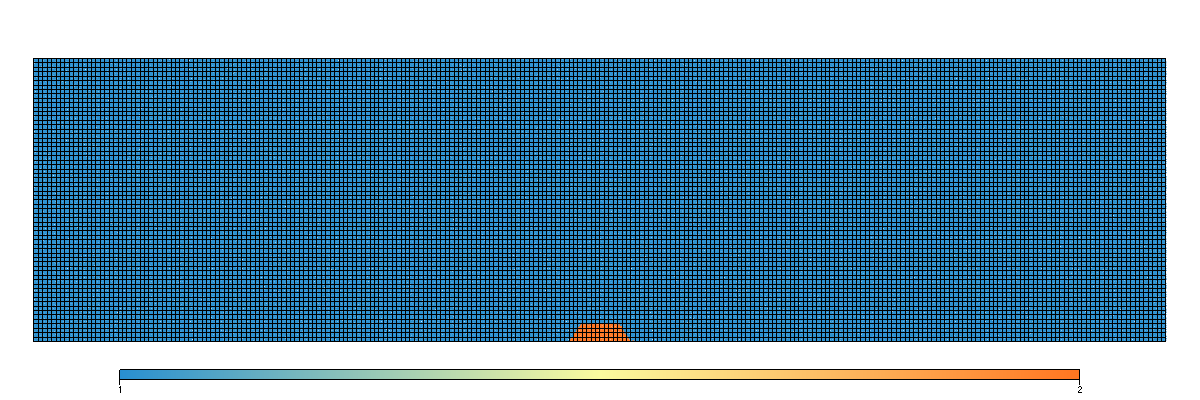

In [25]:
figMat = glucifer.Figure( figsize=(1200,400), boundingBox=((-2.0, 0.0, 0.0), (2.0, 1.0, 0.0)) )
figMat.append( glucifer.objects.Points(swarm,materialVariable, pointSize=2.0) )
figMat.append( glucifer.objects.Mesh(mesh))
#figMat.show()

## Rheology

In [27]:
##Background viscosity

visc0 = 0.01      #if sticky air
visc1 = ndp.eta1
visc2 = ndp.eta2


viscosityMap = { material0: visc0, material1:visc1, material2:visc2 }

backgroundViscosityFn  = fn.branching.map( fn_key = materialVariable, 
                                           mapping = viscosityMap )

### Define a yield criterion (function)

\begin{equation}
    \tau_\textrm{yield} = C(\varepsilon_p) + \mu p 
\end{equation}

The yield strength described above needs to be evaluated on the fly at the particles (integration points). It therefore needs to be a function composed of mesh variables, swarm variables, constants, and mathematical operations.

In [28]:
# Friction - in this form it could also be made to weaken with strain


cohesion0       = fn.misc.constant(ndp.cohesion)
cohesionFn = cohesion0

# Drucker-Prager yield criterion


yieldStressFn   = cohesionFn + ndp.fa * pressureField  

yieldStressFn   = cohesionFn + ndp.fa * fn.misc.max(fn.misc.constant(0.), pressureField) #in this case only positive pressures



### effective viscosity

In [29]:
# first define strain rate tensor

strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

# now compute a viscosity assuming yielding

min_viscosity = visc0  # same as the air ... 

yieldingViscosityFn =  0.5 * yieldStressFn / (strainRate_2ndInvariantFn+1.0e-18)

#viscosityFn = fn.exception.SafeMaths( fn.misc.max(fn.misc.min(yieldingViscosityFn, 
#                                                              backgroundViscosityFn), 
#                                                  min_viscosity))


viscosityFn = fn.exception.SafeMaths( fn.misc.max(
                                              1./((1./yieldingViscosityFn) + (1./backgroundViscosityFn))
                                             , min_viscosity))

### Buoyancy forces

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [30]:
densityMap = { material0: 0.0, material1:ndp.rho, material2:ndp.rho }

densityFn = fn.branching.map( fn_key=materialVariable, mapping=densityMap )

# And the final buoyancy force function.
z_hat = ( 0.0, 1.0 )
buoyancyFn = -densityFn * z_hat

System setup
-----

Setup a Stokes equation system and connect a solver up to it.  

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [31]:
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = velocityBCs,
                               fn_viscosity  = viscosityFn, 
                               fn_bodyforce  = buoyancyFn )

solver = uw.systems.Solver( stokes )

# "mumps" is a good alternative for "lu" but  # use "lu" direct solve and large penalty (if running in serial)

if(uw.nProcs()==1):
    solver.set_inner_method("lu")
    solver.set_penalty(1.0e6) 
    solver.options.scr.ksp_rtol = 1.0e-3

else:
    solver.set_inner_method("mumps")
    solver.set_penalty(1.0e7)
    solver.options.scr.ksp_type="cg"
    solver.options.scr.ksp_rtol = 1.0e-4



In [32]:
#solver.solve( nonLinearIterate=True, nonLinearMaxIterations=20)

In [33]:
#solver._stokesSLE._cself.curResidual

## Manual Picard iteration

In [34]:
prevVelocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )


In [35]:
def volumeint(Fn = 1., rFn=1.):
    return uw.utils.Integral( Fn*rFn,  mesh )


In [ ]:
#The underworld Picard interation applies the following residual (SystemLinearEquations.c)

#/* Calculate Residual */
#      VecAXPY( previousVector, -1.0, currentVector );
#      VecNorm( previousVector, NORM_2, &prevVecNorm );
#      VecNorm( currentVector, NORM_2, &currVecNorm );
#      residual = ((double)prevVecNorm) / ((double)currVecNorm);



count = 0


resVals = []

for i in range(md.maxIts):
    
    prevVelocityField.data[:] = velocityField.data.copy()
    solver.solve( nonLinearIterate=False)
    
    #L2 norm of previous velocity - don't need this 
    
    #v2 = fn.math.dot(prevVelocityField,  prevVelocityField)
    #_Vr = volumeint(v2)
    #prevvelL2 = np.sqrt(_Vr.evaluate()[0])
    
    #L2 norm of current velocity
    v2 = fn.math.dot(velocityField,  velocityField)
    _Vr = volumeint(v2)
    velL2 = np.sqrt(_Vr.evaluate()[0])
    
    
    #L2 norm of delta velocity
    
    delV = velocityField - prevVelocityField
    v2 = fn.math.dot(delV,  delV)
    _Vr = volumeint(v2)
    delvelL2 = np.sqrt(_Vr.evaluate()[0])
    
    res = abs(delvelL2 /velL2)
    resVals.append(res)

    
    count +=1
    print(res)
    print(count)
    
    
    #Converged stopping condition
    if res < md.tol:
        break


In [35]:
#solver._stokesSLE._cself.curResidual


In [37]:
#%pylab inline

#fig, ax = plt.subplots()
#ax.scatter(range(len(resVals)), resVals)
#ax.set_yscale('log')
#ax.set_ylim(0.0005, 1.)

In [38]:
#((20e3*1e-15)*3600*365*24)*100.

## Make a swarm to represent coulomb angle

## Figures

In [144]:
lithPressureFn = ndp.rho* (1. - coord[1])

In [40]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

(area,) = surfaceArea.evaluate()
(p0,) = surfacePressureIntegral.evaluate() 

pressureField.data[:] -= p0 / area


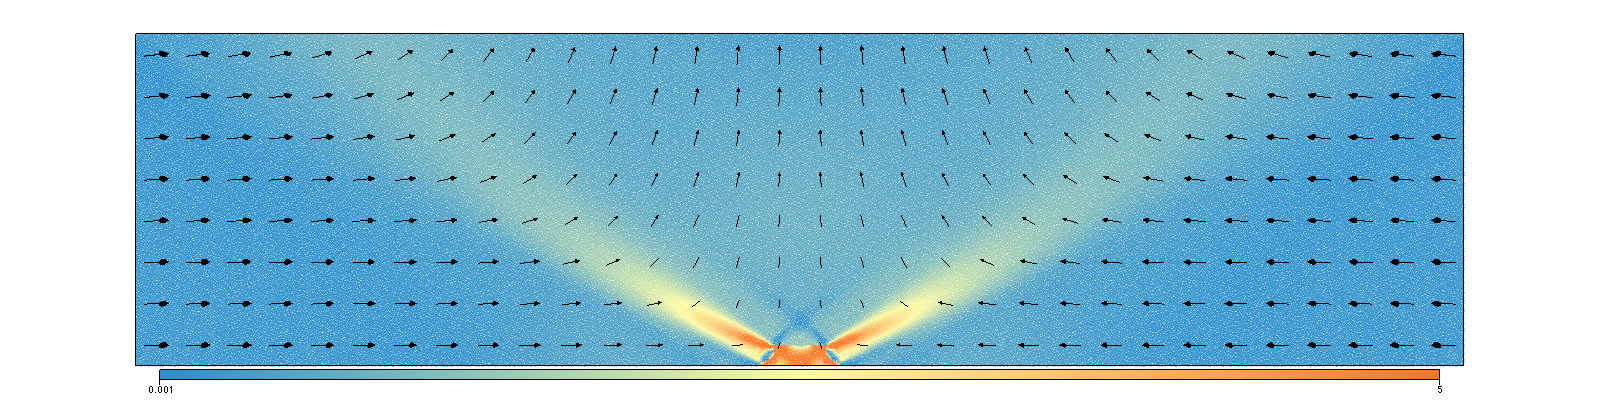

In [63]:
figSinv = glucifer.Figure( figsize=(1600,400), boundingBox=((-2.0, 0.0, 0.0), (2.0, 1.0, 0.0)) )
figSinv .append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=0.25, scaling=.075, resolutionI=32, resolutionJ=8) )

figSinv .append( glucifer.objects.Points(swarm,strainRate_2ndInvariantFn, pointSize=2.0, valueRange=[1e-3, 5.]) )
#figSinv.show()


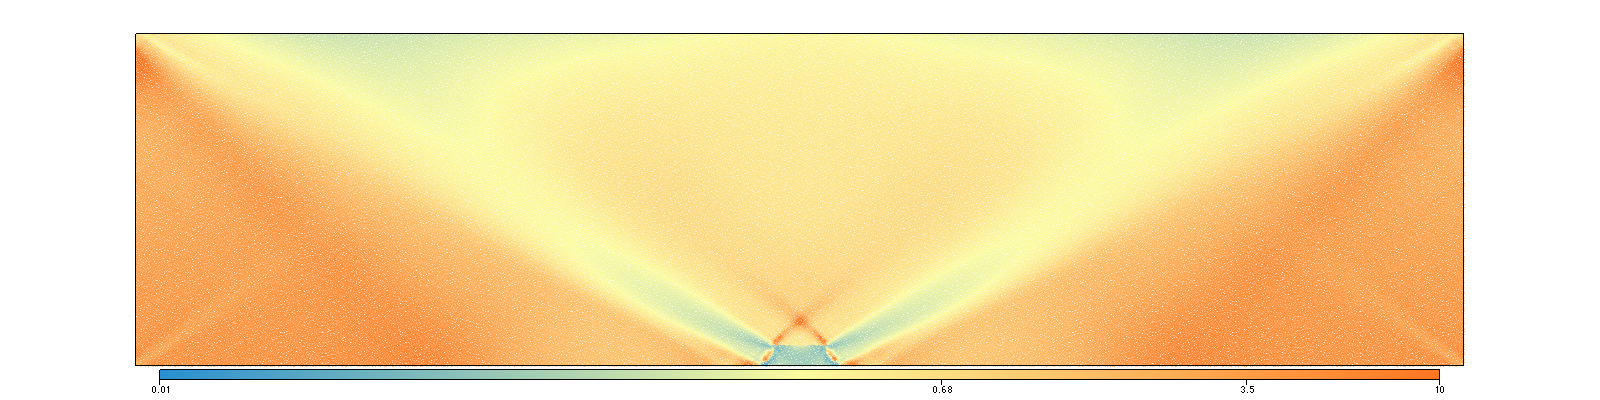

In [85]:
figVisc = glucifer.Figure( figsize=(1600,400), boundingBox=((-2.0, 0.0, 0.0), (2.0, 1.0, 0.0)) )

figVisc.append( glucifer.objects.Points(swarm, yieldingViscosityFn, pointSize=2.0, logScale=True,valueRange=[0.01, 10] ) )
#figVisc.show()


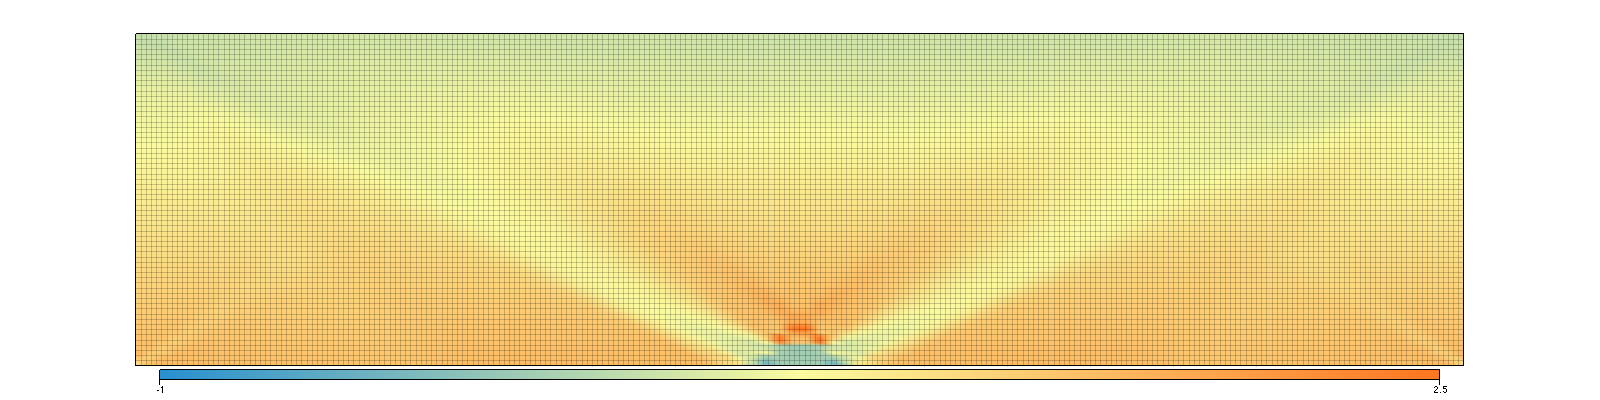

In [145]:
figPres= glucifer.Figure( figsize=(1600,400), boundingBox=((-2.0, 0.0, 0.0), (2.0, 1.0, 0.0)) )
figPres.append( glucifer.objects.Surface(mesh, (pressureField - lithPressureFn), valueRange=[-1.,2.5] ))
#figPres.draw.label(r'$\sin (x)$', (0.2,0.7,0))
figPres.append( glucifer.objects.Mesh(mesh,opacity=0.2))

#figPres.show()

In [98]:
figSinv.save_image(imagePath + "figSinv.png")

figVisc.save_image(imagePath +  "figVisc.png")

figPres.save_image(imagePath + "figPres.png")

'results/T/0/images/figPres.png'

In [115]:
velocityField.save(filePath + "vel.h5")
pressureField.save(filePath + "pressure.h5")

## Save points to determine shear band angle

In [147]:
eii_mean = uw.utils.Integral(strainRate_2ndInvariantFn,mesh).evaluate()[0]/4.

eii_std = uw.utils.Integral(fn.math.sqrt(0.25*(strainRate_2ndInvariantFn - eii_mean)**2.), mesh).evaluate()[0]


In [245]:
#grab all of material points that are above 2 sigma of mean strain rate invariant



xv, yv = np.meshgrid(
        np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0]), 
        np.linspace(mesh.minCoord[1], mesh.maxCoord[1], mesh.elementRes[1]))

meshGlobs = np.row_stack((xv.flatten(), yv.flatten())).T

eII_2sig = eii_mean  + 2.*eii_std

In [246]:
shearbandswarm  = uw.swarm.Swarm( mesh=mesh, particleEscape=True )
shearbandswarmlayout  = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=shearbandswarm , particlesPerCell=int(md.ppc/16.) )
shearbandswarm.populate_using_layout( layout=shearbandswarmlayout )

In [247]:
#shearbandswarm.particleGlobalCount

In [248]:
np.unique(strainRate_2ndInvariantFn.evaluate(shearbandswarm) < eII_2sig)

array([False,  True], dtype=bool)

In [249]:
with shearbandswarm.deform_swarm():
    mask = np.where(strainRate_2ndInvariantFn.evaluate(shearbandswarm) < eII_2sig)
    shearbandswarm.particleCoordinates.data[mask[0]]= (1e20, 1e20)

shearbandswarm.update_particle_owners()    

with shearbandswarm.deform_swarm():
    mask = np.where((shearbandswarm.particleCoordinates.data[:,1] < ndp.asthenosphere + notchWidth) | 
                    (shearbandswarm.particleCoordinates.data[:,1] >  1. - notchWidth) )
    shearbandswarm.particleCoordinates.data[mask]= (1e20, 1e20)

shearbandswarm.update_particle_owners()


with shearbandswarm.deform_swarm():
    mask = np.where(shearbandswarm.particleCoordinates.data[:,0] > -2.*notchWidth)
    shearbandswarm.particleCoordinates.data[mask]= (1e20, 1e20)
                    
shearbandswarm.update_particle_owners()


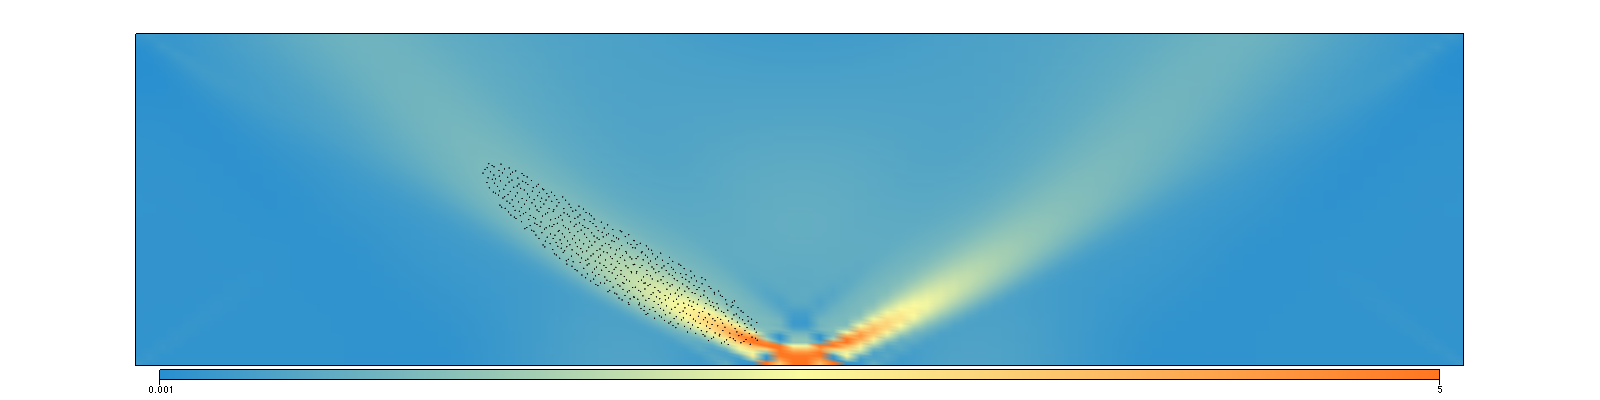

In [250]:
figTest = glucifer.Figure( figsize=(1600,400), boundingBox=((-2.0, 0.0, 0.0), (2.0, 1.0, 0.0)) )
figTest.append( glucifer.objects.Points(shearbandswarm, pointSize=2.0, colourBar=False) )

#figTest.append( glucifer.objects.Points(swarmCustom , pointSize=4.0,colourBar=False) )


figTest .append( glucifer.objects.Surface(mesh,strainRate_2ndInvariantFn, valueRange=[1e-3, 5.]) )
#figTest.show()

In [230]:
figTest.save_image(imagePath +  "figTest.png")


'results/T/0/images/figTest.png'

In [231]:
shearbandswarm.save(filePath + 'swarm.h5')

## Calculate and save some metrics

In [265]:
sqrtv2 = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
sqrtv2x = fn.math.sqrt(fn.math.dot(velocityField[0],velocityField[0]))


_rmsint = uw.utils.Integral(sqrtv2, mesh)

_rmsSurf = uw.utils.Integral(sqrtv2x, mesh, integrationType='Surface',surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

_viscMM = fn.view.min_max(viscosityFn)
dummyFn = _viscMM.evaluate(swarm)

_eiiMM = fn.view.min_max(strainRate_2ndInvariantFn)
dummyFn = _eiiMM.evaluate(swarm)


In [266]:
#_viscMM.min_global(), _viscMM.max_global()
#_eiiMM.min_global(), _eiiMM.max_global()

rmsint = _rmsint.evaluate()[0]
rmsSurf = _rmsSurf.evaluate()[0]


## scratch

In [273]:
import h5py

In [279]:
fname = filePath + 'swarm.h5'

if uw.rank()==0:
    with h5py.File(fname,'r') as hf:
        #print('List of arrays in this file: \n', hf.keys())
        data = hf.get('data')
        np_data = np.array(data)

    sbx =  np_data[:,0]
    sby =  np_data[:,1]

    #sbx =  shearbandswarm.particleCoordinates.data[:,0]
    #sby =  shearbandswarm.particleCoordinates.data[:,1]

    z = np.polyfit(sbx, sby, 1)
    p = np.poly1d(z)
    newcoords = np.column_stack((sbx, p(sbx)))
    angle = math.atan(z[0])*(180./math.pi)
    45. - dp.fa

    

In [283]:
comm.barrier()
comm.Bcast(newcoords, root = 0)

In [288]:
figTest2 = glucifer.Figure( figsize=(1600,400), boundingBox=((-2.0, 0.0, 0.0), (2.0, 1.0, 0.0)) )
figTest2.append( glucifer.objects.Points(shearbandswarm, pointSize=2.0, colourBar=False) )

figTest2.append( glucifer.objects.Points(swarmCustom , pointSize=4.0,colourBar=False) )


figTest2.append( glucifer.objects.Surface(mesh,strainRate_2ndInvariantFn, valueRange=[1e-3, 5.]) )
#figTest2.show()

figTest2.save_image(imagePath +  "figTest2.png")


'results/T/0/images/figTest2.png'

In [ ]:
if uw.rank()==0:
    f_o.write((6*'%-15s ' + '\n') % (rmsint,rmsSurf, _viscMM.min_global(), 
                                      _viscMM.max_global(),_eiiMM.min_global(), _eiiMM.max_global(), angle ))
    
    f_o.writelines(["%s\n" % item for item in resVals])

            
f_o.close()